1. Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.
2. Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции. *Оформите в виде класса с методами.
3. Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.
4. Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).
5. Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).
6. Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.

https://habr.com/ru/post/318970/

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math

In [2]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data = data[data["target"]<=1]
y = data["target"]
X = data.drop("target", axis=1)

In [3]:
# log regression for multiple inputs
class MyLogRes:
    def __init__(self, learning_rate=0.01, max_iter=1000, eps=1e-5, fit_method="gradient_descent"):
        self.alpha = learning_rate
        self.max_iter = max_iter
        self.eps = eps
        self.losses = []
        self.fit_method = fit_method

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    def loss_func(self, X, y):
        z = np.dot(X, self.w) + self.b
        return -np.mean(y*np.log(self.sigmoid(z)) + (1-y)*np.log(1-self.sigmoid(z)))

    # fit log regression using RMSProp
    def fit_rmsprop(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        gamma = 0.9
        eps = 1e-8
        v_w = 0
        v_b = 0
        for i in range(self.max_iter):
            z = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(z)
            v_w = gamma*v_w + (1-gamma)*np.dot(X.T, (y_pred - y))
            v_b = gamma*v_b + (1-gamma)*np.sum(y_pred - y)
            self.w -= self.alpha * (1/X.shape[0]) * v_w / (np.sqrt(np.sum(v_w**2)) + eps)
            self.b -= self.alpha * (1/X.shape[0]) * v_b / (np.sqrt(np.sum(v_b**2)) + eps)
            self.loss = self.loss_func(X, y)
            self.losses.append(self.loss)
            if self.loss < self.eps:
                break
        return self


    # fit log regression using NADAM
    def fit_nadam(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        gamma = 0.9
        beta = 0.999
        eps = 1e-8
        v_w = 0
        v_b = 0
        m_w = 0
        m_b = 0
        for i in range(self.max_iter):
            z = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(z)
            m_w = gamma*m_w + (1-gamma)*np.dot(X.T, (y_pred - y))
            m_b = gamma*m_b + (1-gamma)*np.sum(y_pred - y)
            v_w = beta*v_w + (1-beta)*np.dot(X.T, (y_pred - y))**2
            v_b = beta*v_b + (1-beta)*np.sum((y_pred - y))**2
            m_w_hat = m_w / (1-gamma**(i+1))
            m_b_hat = m_b / (1-gamma**(i+1))
            v_w_hat = v_w / (1-beta**(i+1))
            v_b_hat = v_b / (1-beta**(i+1))
            self.w -= self.alpha * (1/X.shape[0]) * m_w_hat / (np.sqrt(v_w_hat) + eps)
            self.b -= self.alpha * (1/X.shape[0]) * m_b_hat / (np.sqrt(v_b_hat) + eps)
            self.loss = self.loss_func(X, y)
            self.losses.append(self.loss)
            if self.loss < self.eps:
                break
        return self

    # fit using gradient_descent
    def fit_gradient_descent(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for i in range(self.max_iter):
            z = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(z)
            self.w -= self.alpha * (1/X.shape[0]) * np.dot(X.T, (y_pred - y))
            self.b -= self.alpha * (1/X.shape[0]) * np.sum(y_pred - y)
            self.loss = self.loss_func(X, y)
            self.losses.append(self.loss)
            if self.loss < self.eps:
                break
        return self

    def fit(self, X, y):
        if self.fit_method == "rmsprop":
            self.fit_rmsprop(X, y)
        elif self.fit_method == "nadam":
            self.fit_nadam(X, y)
        else:
            self.fit_gradient_descent(X, y)
        return self

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        return np.round(self.sigmoid(z))

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

1.0


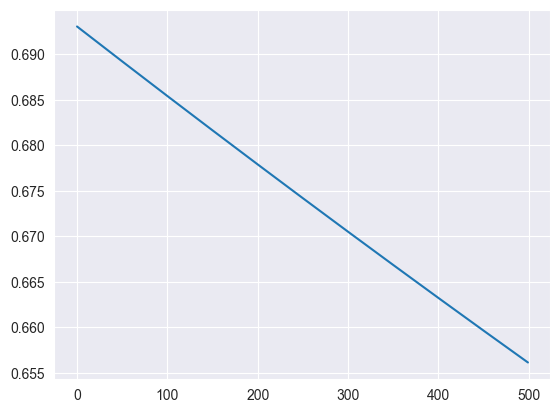

In [5]:
my_lr = MyLogRes(learning_rate=0.0001, max_iter=500, fit_method="gradient_descent")
my_lr.fit(X_train, y_train)
print(my_lr.score(X_test, y_test))
plt.plot(my_lr.losses)

1.0


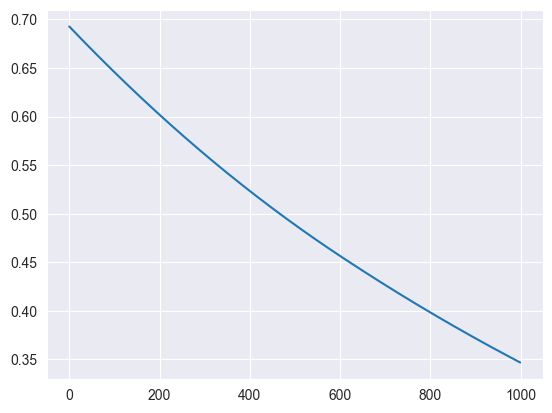

In [6]:
my_lr = MyLogRes(fit_method="rmsprop")
my_lr.fit(X_train, y_train)
print(my_lr.score(X_test, y_test))
plt.plot(my_lr.losses)

1.0


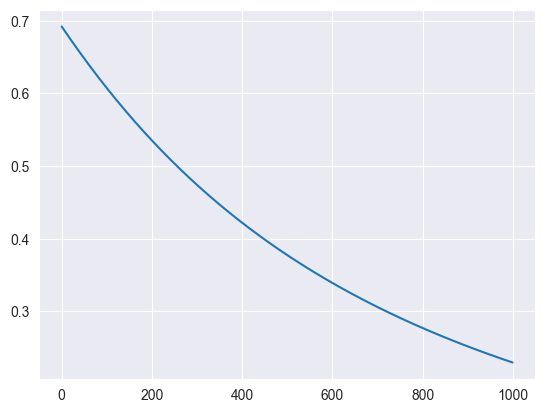

In [7]:
my_lr = MyLogRes(fit_method="nadam")
my_lr.fit(X_train, y_train)
print(my_lr.score(X_test, y_test))
plt.plot(my_lr.losses)

ПРОВЕРКА

In [8]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))


1.0
